# Getting started

In [1]:
import pymultipleis as pym

In [2]:
import numpy as onp
import jax.numpy as jnp

In [3]:
# Load the file containing the frequencies
F = jnp.asarray(onp.load('../../../data/redox_exp_50/freq_50.npy'))
# Load the file containing the admittances (a set of 50 spectra)
Y = jnp.asarray(onp.load('../../../data/redox_exp_50/Y_50.npy'))
# Load the file containing the standard deviation of the admittances
Yerr = jnp.asarray(onp.load('../../../data/redox_exp_50/sigma_Y_50.npy'))


In [4]:
print(F.shape)
print(Y.shape)
print(Yerr.shape)

(45,)
(45, 50)
(45, 50)


In [5]:
def par(a, b):
    """
    Defines the total impedance of two circuit elements in parallel
    """
    return 1/(1/a + 1/b)

def redox(p, f):
    w = 2*jnp.pi*f                      # Angular frequency
    s = 1j*w                            # Complex variable
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rct = p[3]
    Wct = p[4]
    Rw = p[5]
    Zw = Wct/jnp.sqrt(w) * (1-1j)       # Planar infinite length Warburg impedance
    Zdl = 1/(s**nh*Qh)                  # admittance of a CPE
    Z = Rs + par(Zdl, Rct + par(Zw, Rw))
    Y = 1/Z
    return jnp.concatenate((Y.real, Y.imag), axis = 0)


In [6]:
# def redox(p, f):
#     w = 2*jnp.pi*f               # Angular frequency
#     s = 1j*w                       # Complex variable
#     Rs = p[0]
#     Qh = p[1]
#     nh = p[2]
#     Rct = p[3]
#     Wct = p[4]
#     Rw = p[5]
#     Zw = Wct/jnp.sqrt(w) * (1-1j) # Planar infinite length Warburg impedance
#     Ydl = s**nh * Qh                # admittance of a CPE
#     Z1 = (1/Zw + 1/Rw)**-1
#     Z2 = (Rct+Z1)
#     Y2 = Z2**-1
#     Y3 = (Ydl + Y2)
#     Z3 = 1/Y3
#     Z = Rs + Z3
#     Y = 1/Z
#     return jnp.concatenate((Y.real, Y.imag), axis = 0)


In [6]:
p0 = jnp.asarray([1.6295e+02, 3.0678e-08, 9.3104e-01, 1.1865e+04, 4.7125e+05, 1.3296e+06])

bounds = [[1e-15,1e15], [1e-9, 1e2], [1e-1,1e0], [1e-15,1e15], [1e-15,1e15], [1e-15,1e15]]

smf_sigma = jnp.asarray([100000., 100000., 100000., 100000., 100000., 100000.]) # Smoothing factor used with the standard deviation

smf_modulus = jnp.asarray([1., 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

smf_inf = jnp.asarray([jnp.inf, 1., 1., 1., 1., 1.]) # Smoothing factor used with the modulus

labels = {"Rs":"$\Omega$", "Qh":"$F^{nh}$", "nh":"-", "Rct":"$\Omega$", "Wct":"$\Omega\cdot s^{-0.5}$", "Rw":"$\Omega$"}



## 1. using the standard deviation as weighting

In [8]:
eis_redox_sigma = pym.Multieis(p0, F, Y, bounds, smf_sigma, redox, weight= Yerr, immittance='admittance')


Using initial

Optimization complete
total time is 0:00:15.647183 

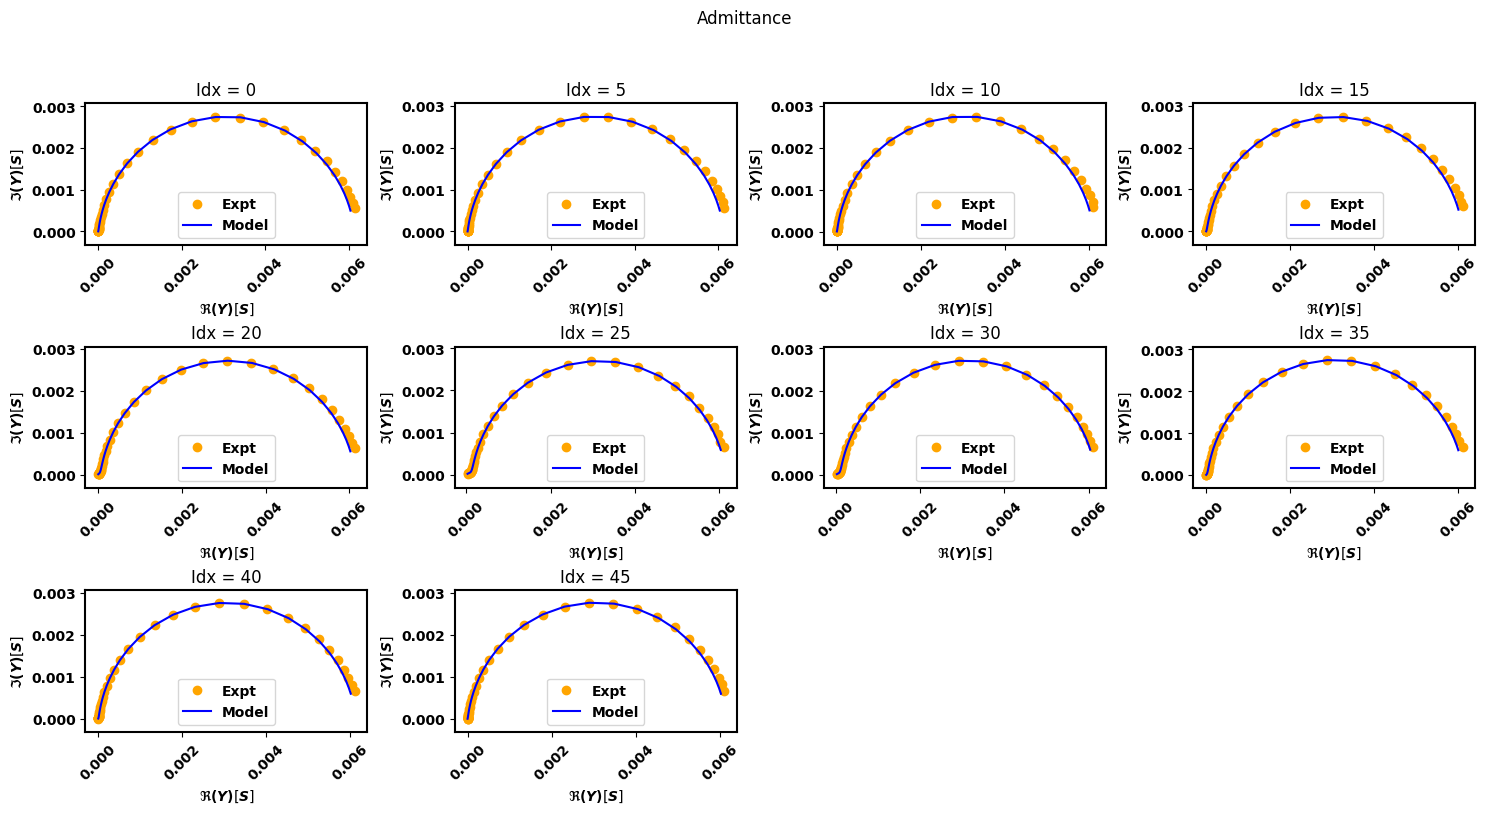

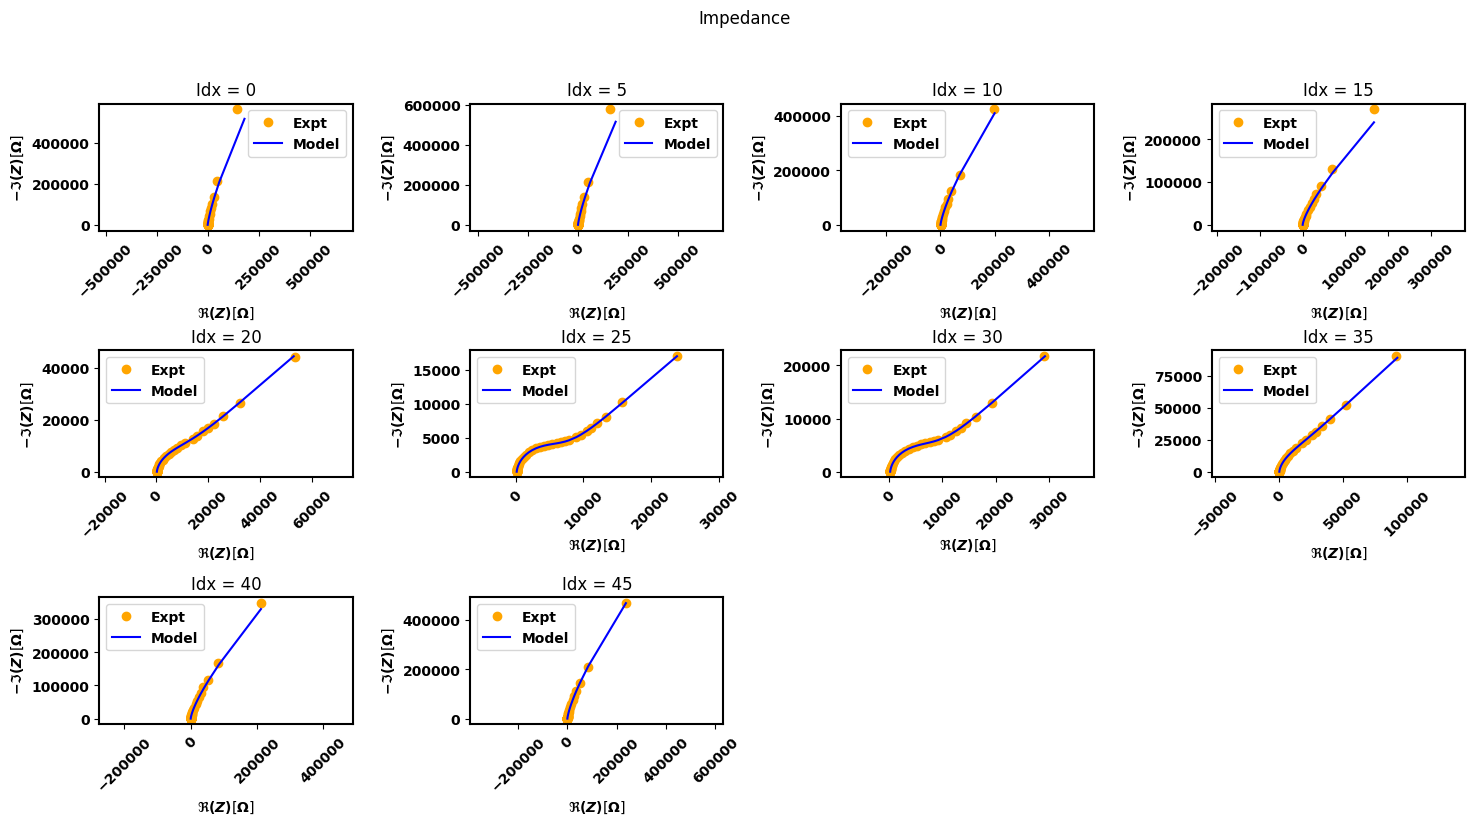

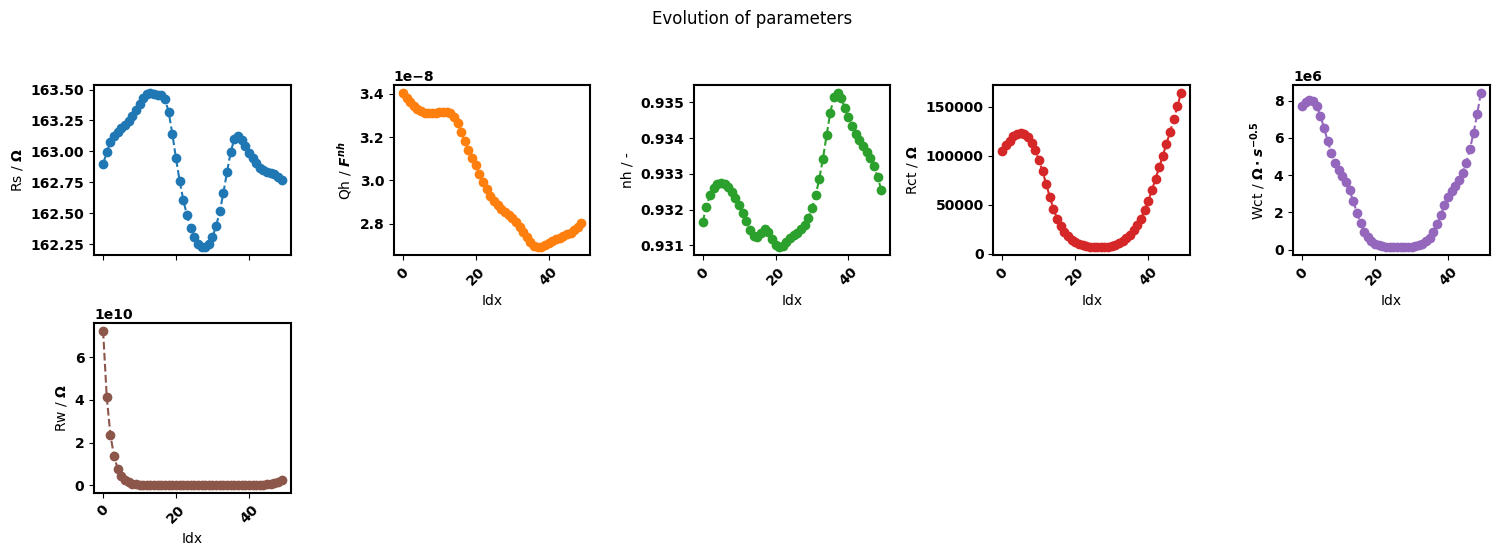

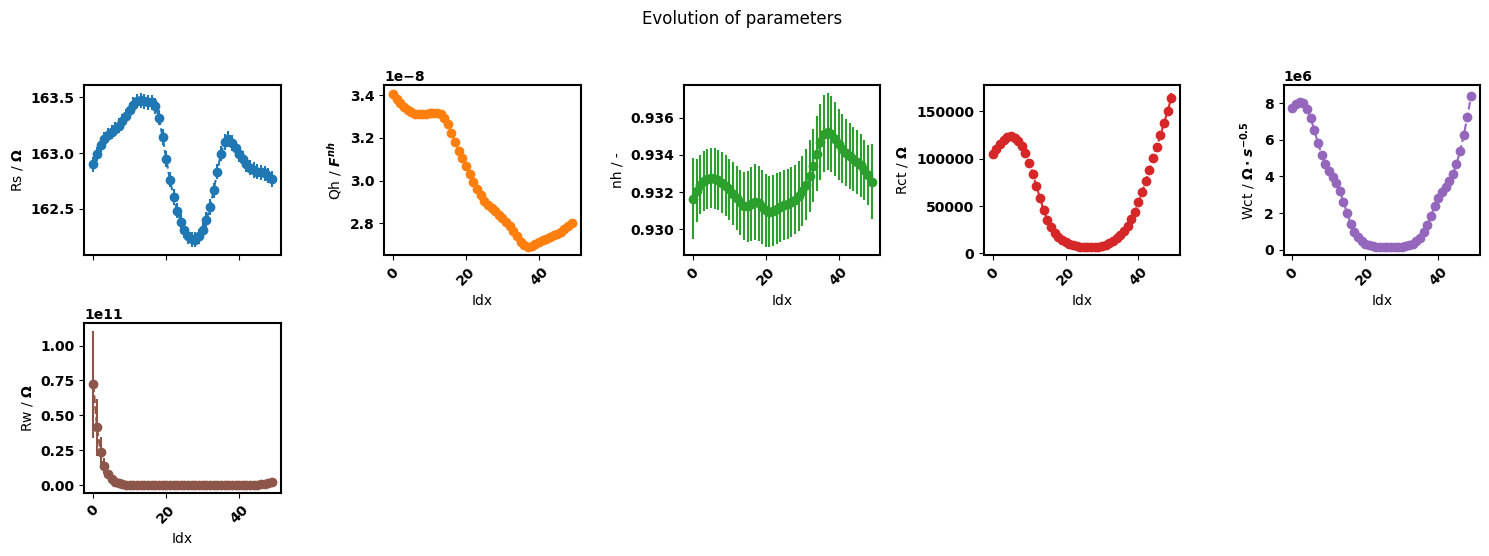

In [9]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous(method = 'tnc')
eis_redox_sigma.plot_nyquist(5)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)


Using prefit

Optimization complete
total time is 0:00:09.716980 

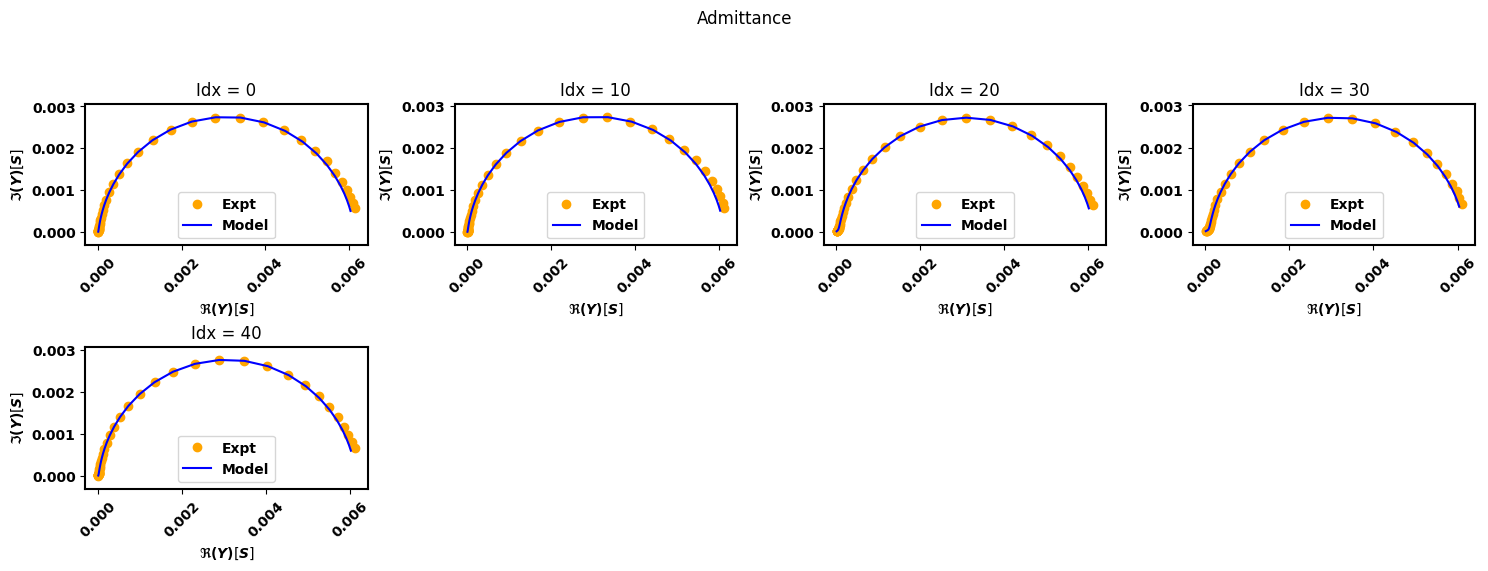

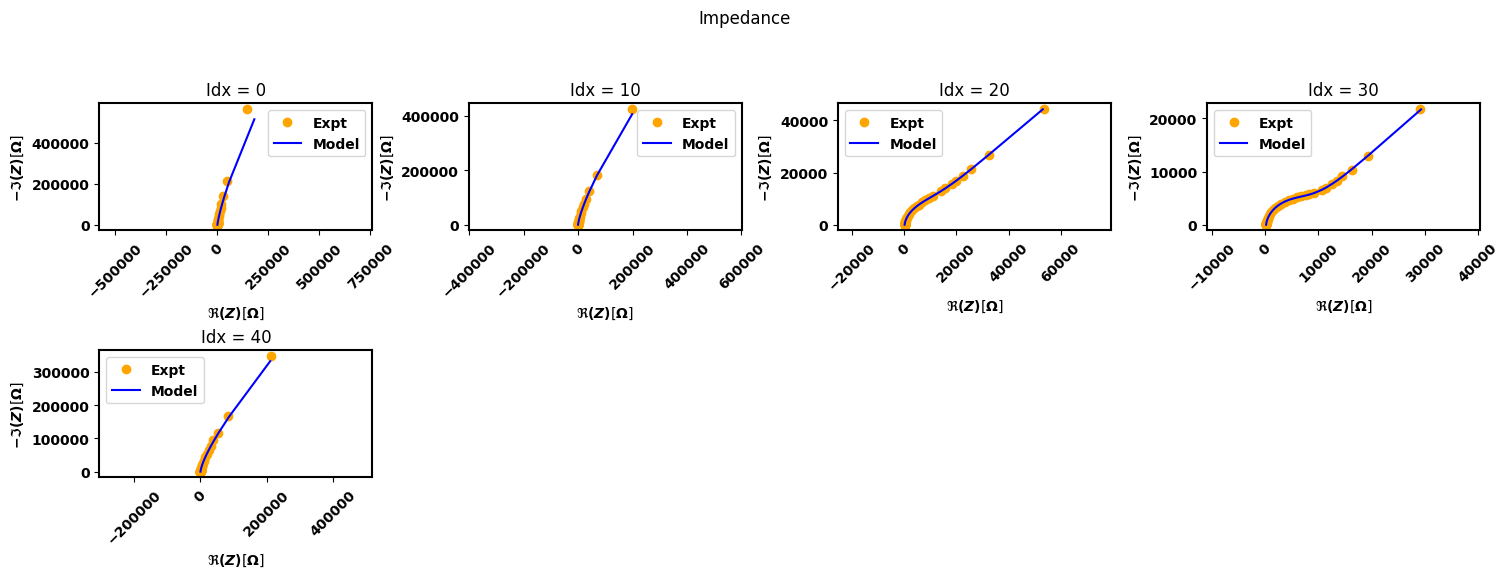

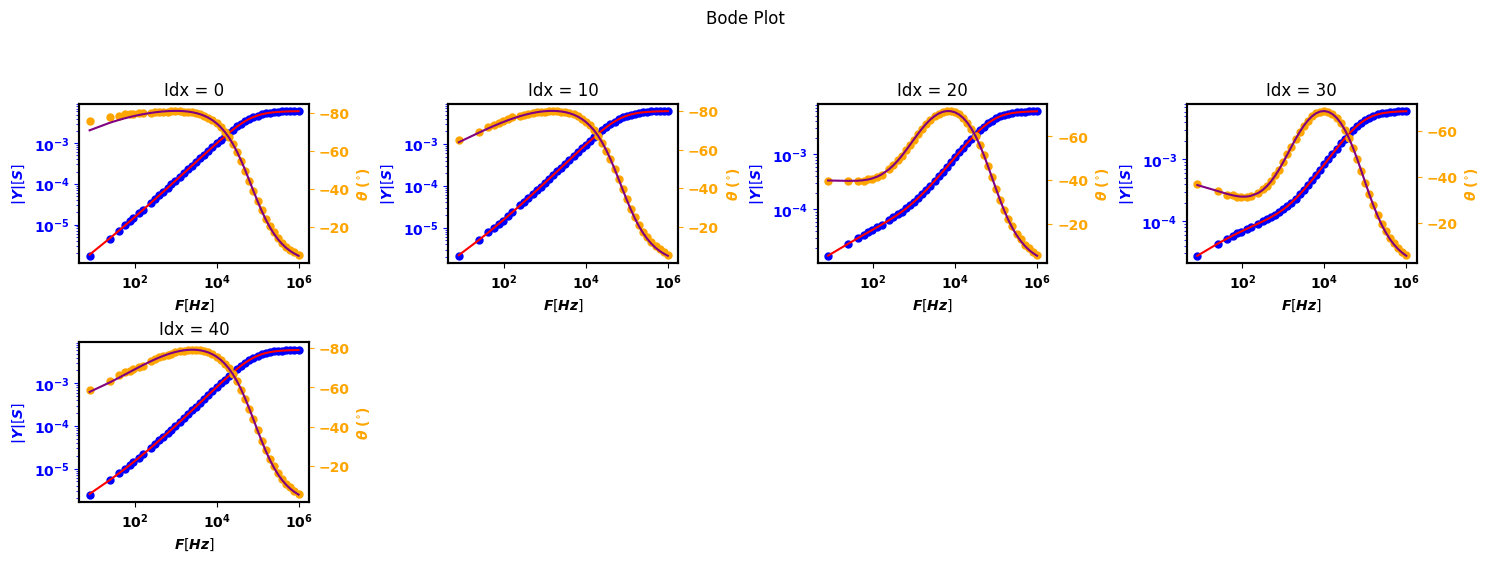

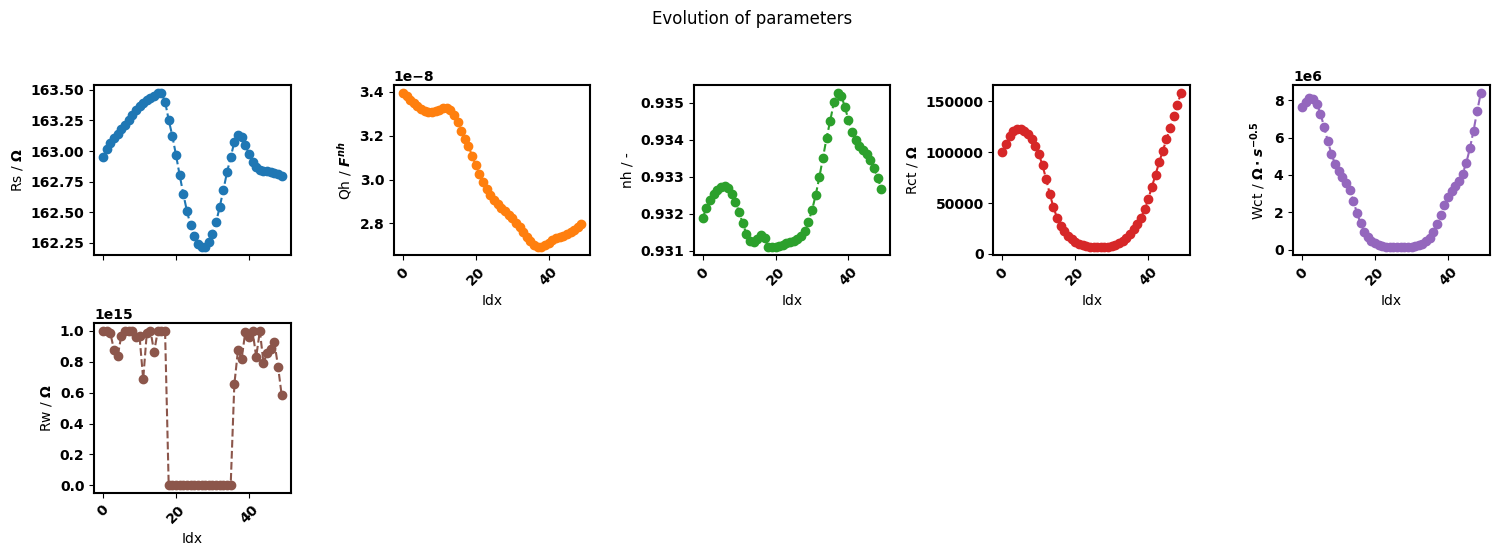

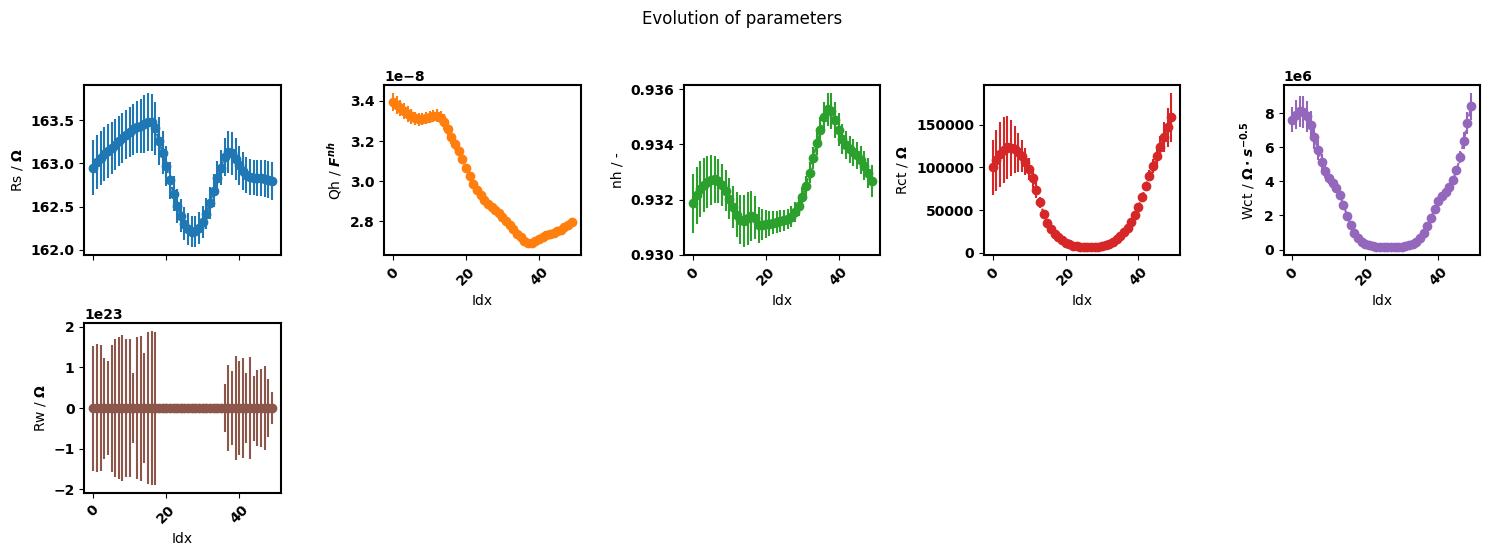

In [10]:
popt, perr, chisqr, chitot, AIC = eis_redox_sigma.fit_simultaneous_zero()
eis_redox_sigma.plot_nyquist(10)
eis_redox_sigma.plot_bode(steps = 10)
eis_redox_sigma.plot_params(labels=labels)
eis_redox_sigma.plot_params(True, labels=labels)

## 2. Using the modulus as weighting

There are many cases where we do not have the data for the standard deviation of the admittance or impedance. ``pymultipleis`` offers other weighting options. 
In this second example we shall fit using the modulus as the weighting. All you need do is set the weight to the string "modulus".


Using initial

Optimization complete
total time is 0:00:12.533008 

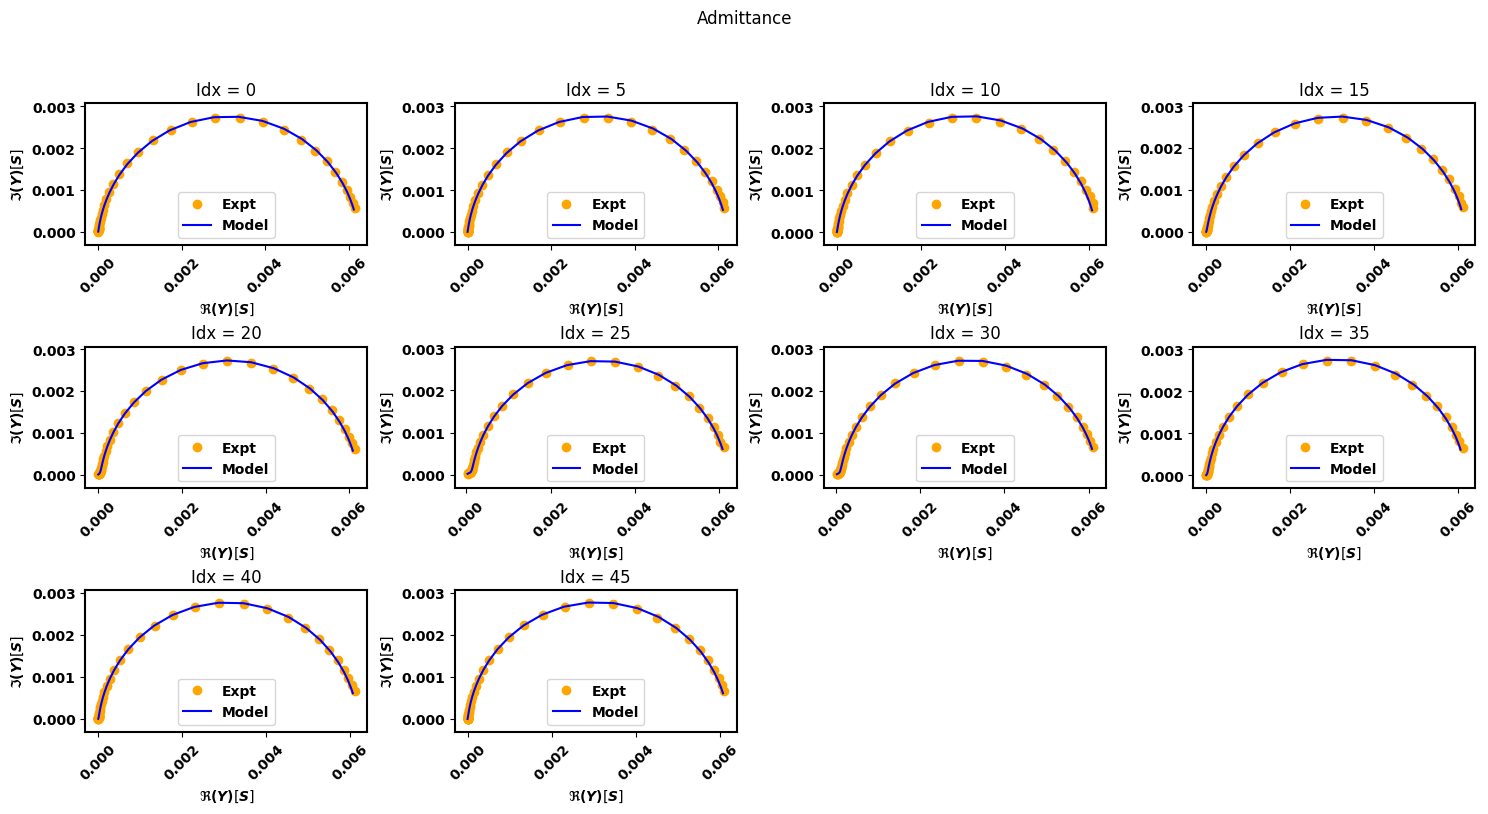

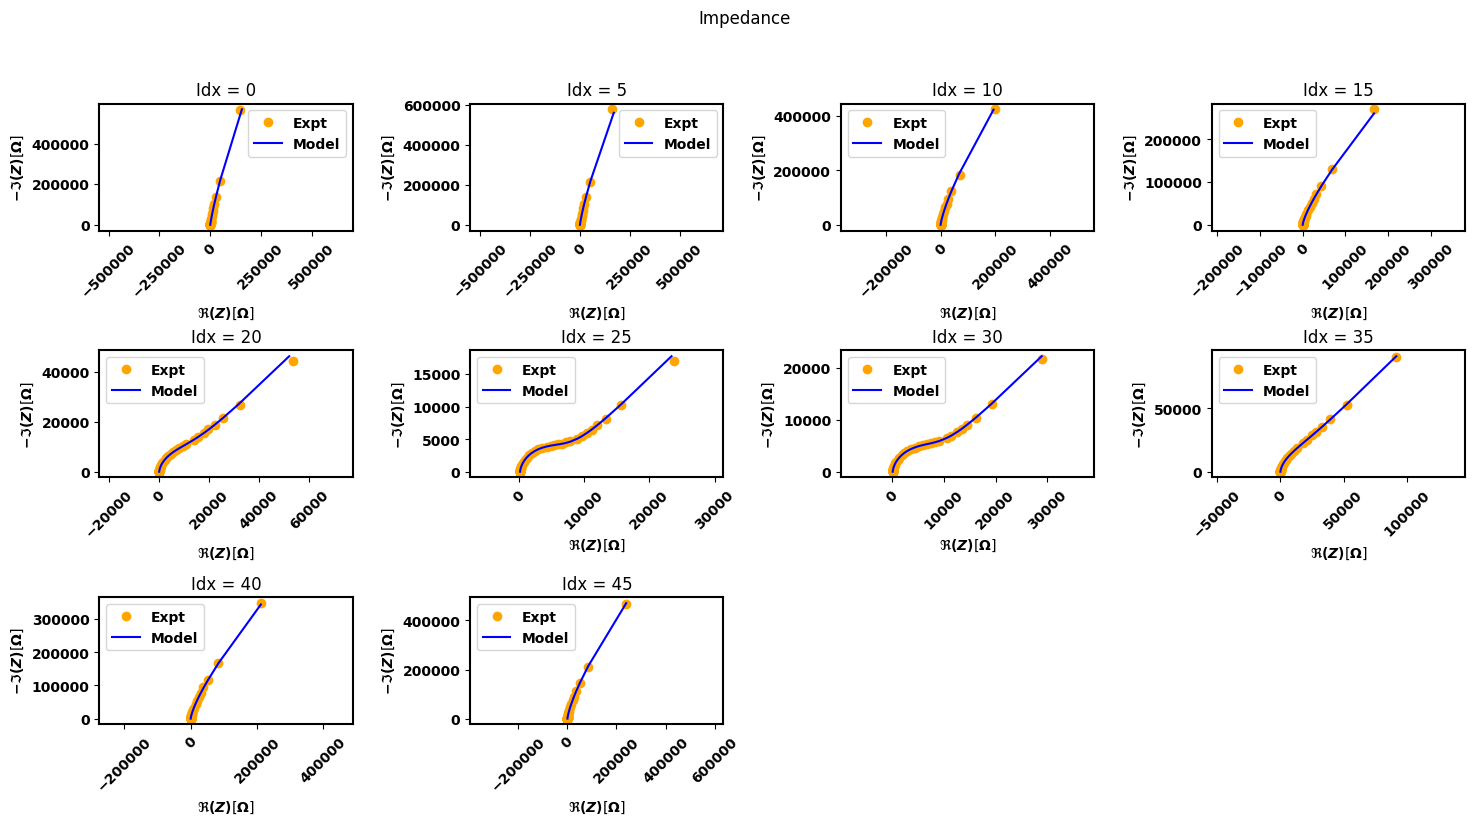

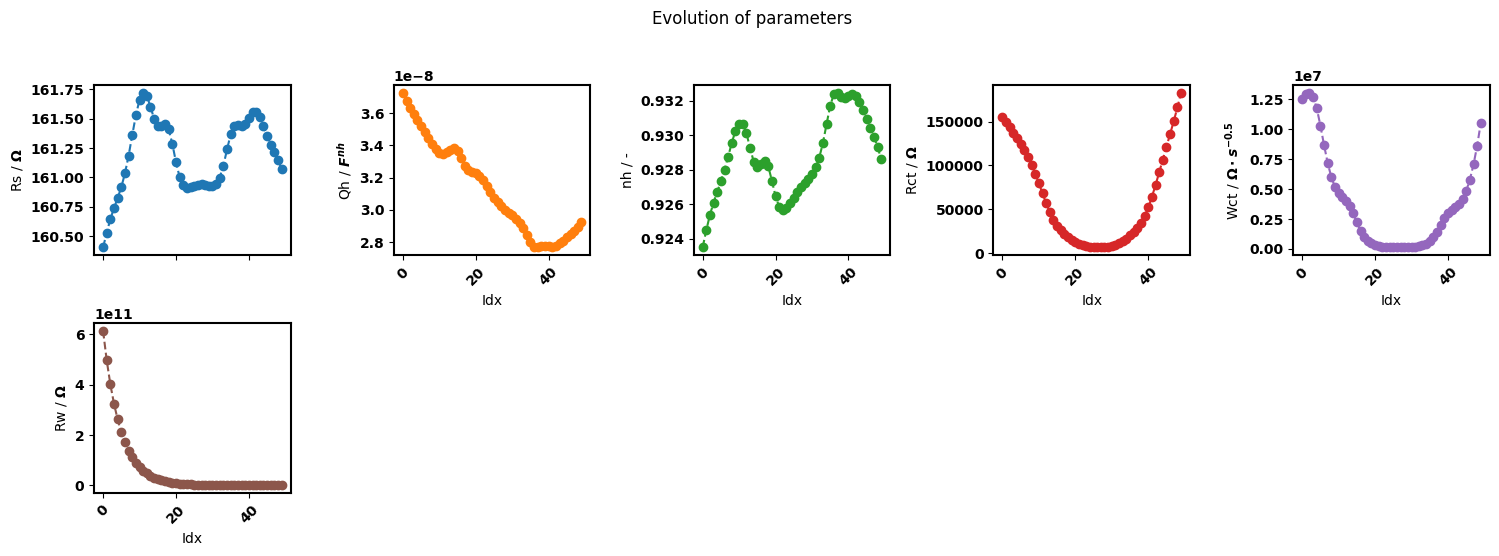

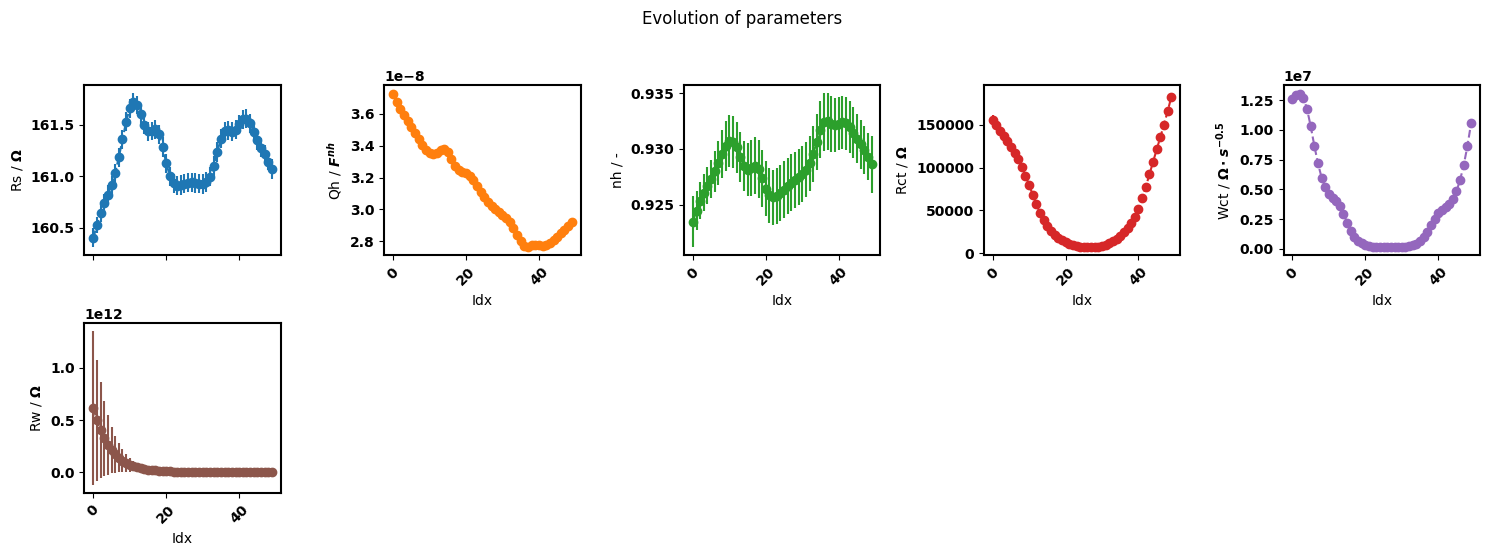

In [7]:
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)

In [8]:
print(chitot)

3.742554443579488e-05



Using prefit

Optimization complete
total time is 0:00:13.526634 

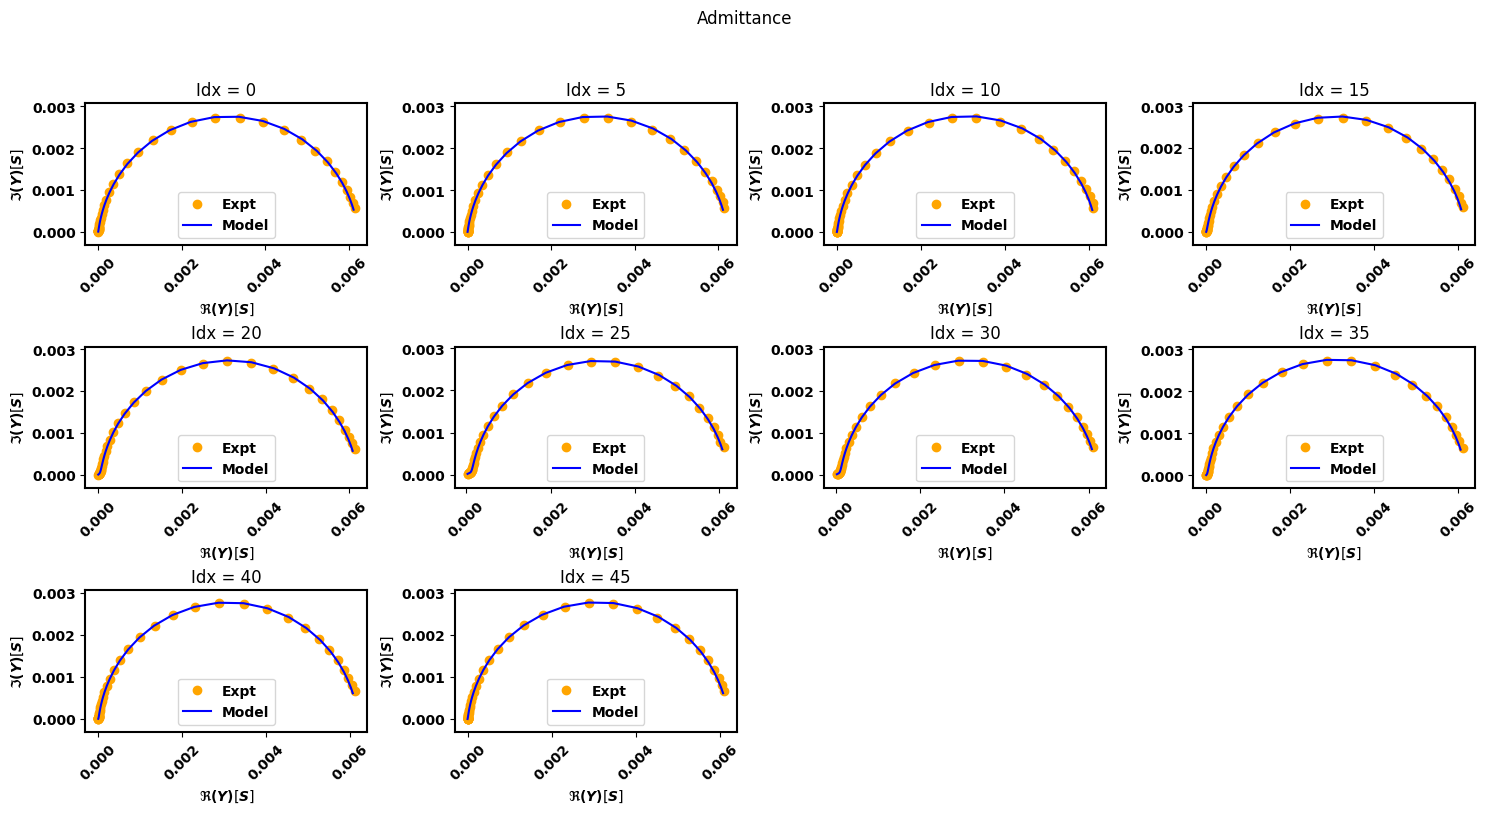

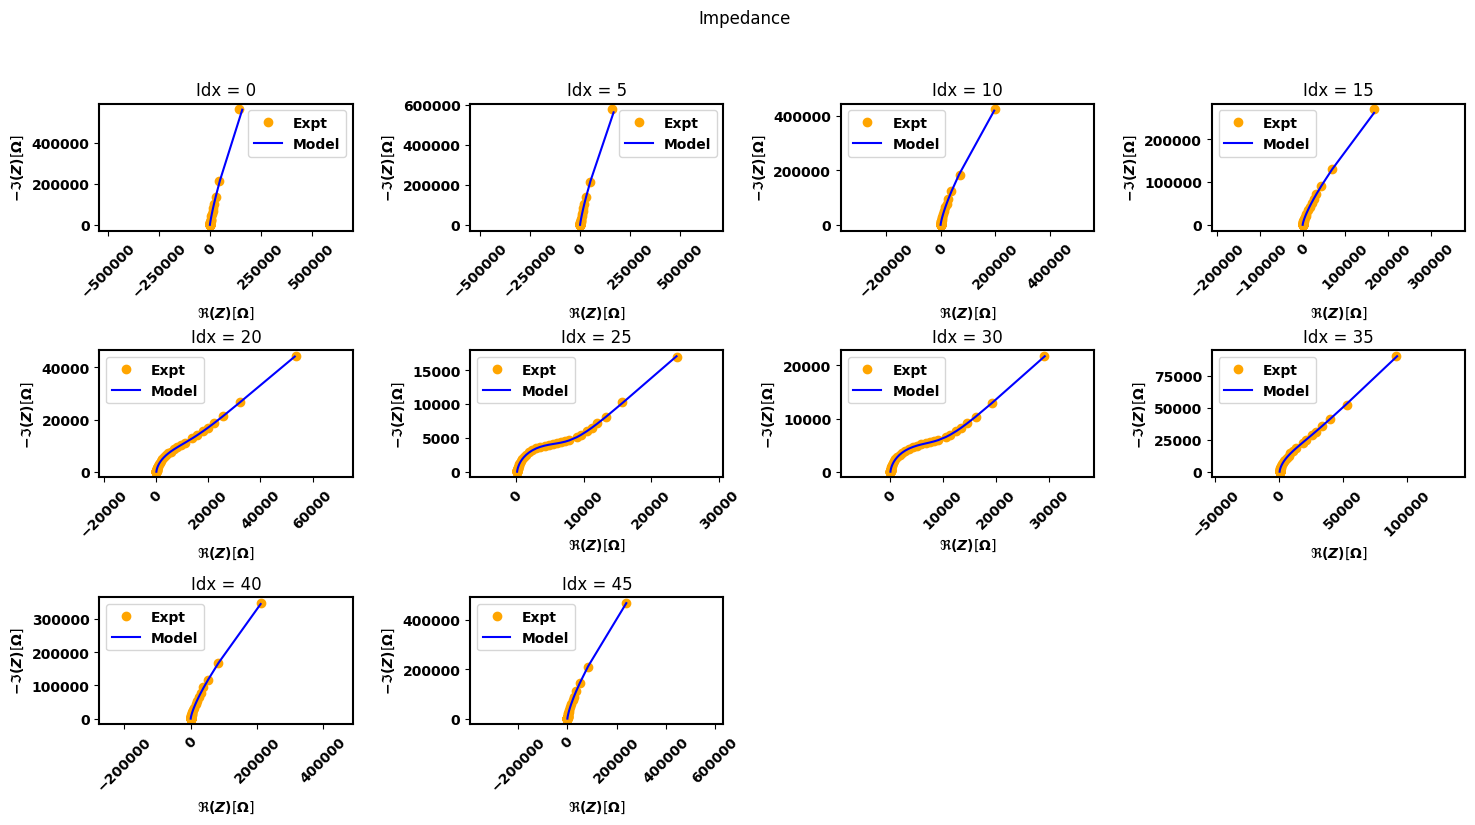

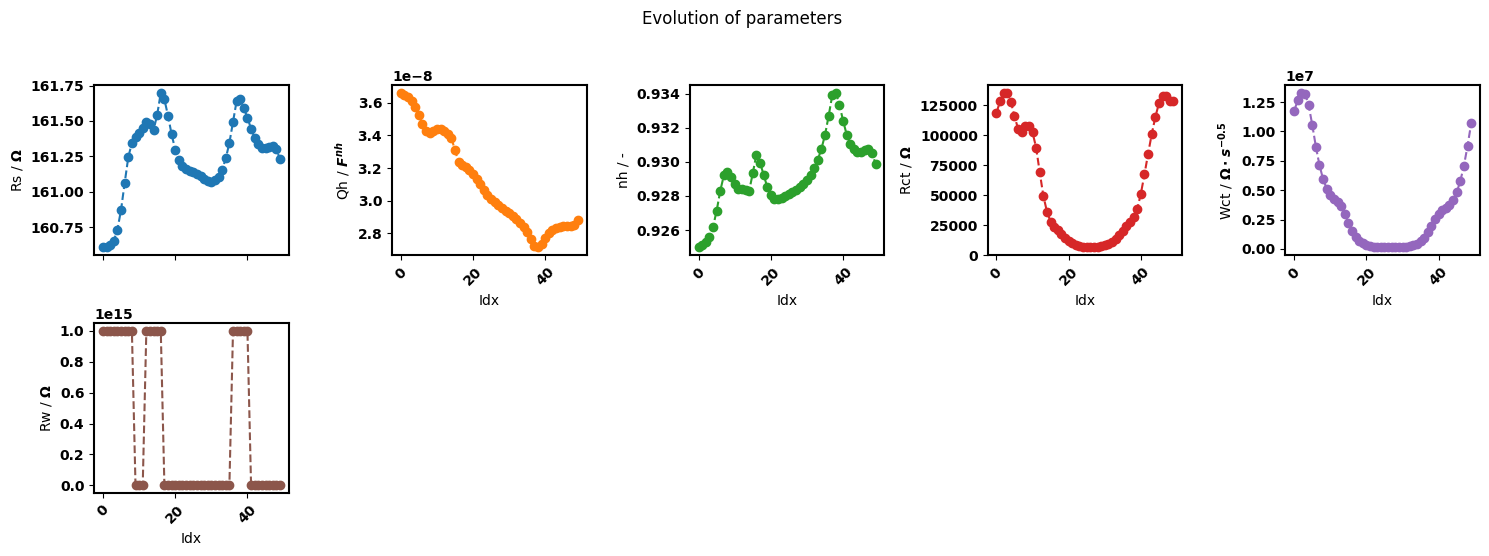

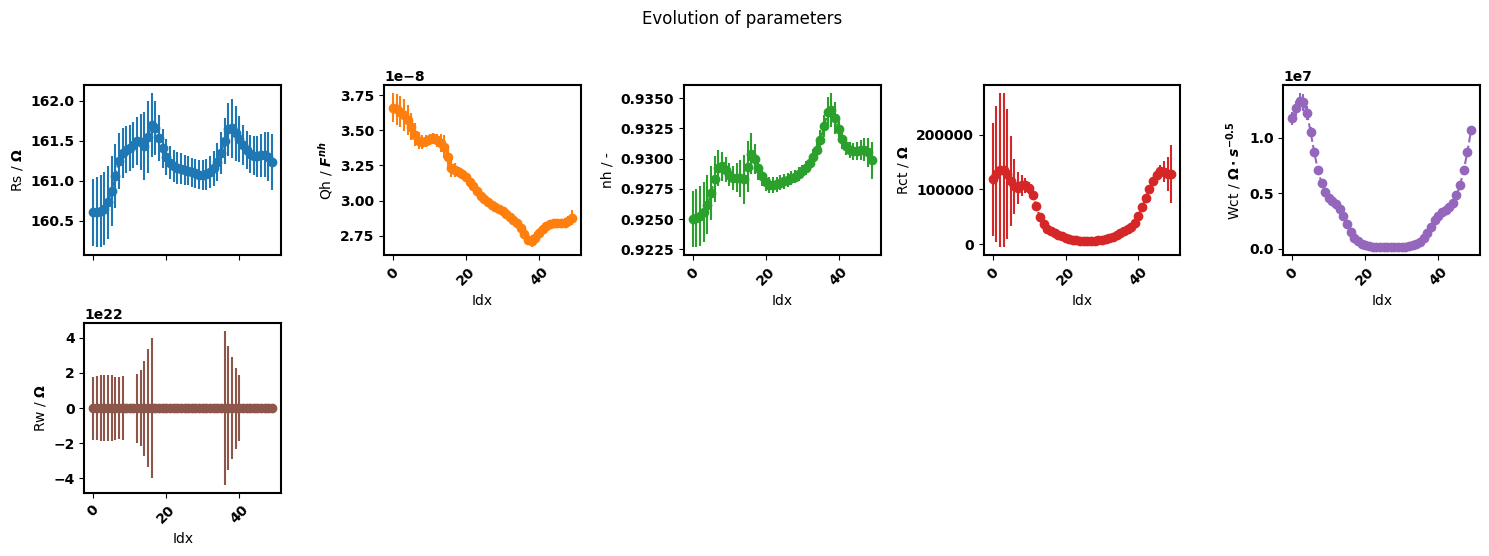

In [13]:
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous_zero(method='bfgs')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(labels=labels)
eis_redox_modulus.plot_params(True, labels=labels)

### Make a least squares fit directly after running `fit_simultaneous()`
Here fit_sequential() uses the optimal parameters produced from fit_simultaneous() as initial guesses.


Using initial

Optimization complete
total time is 0:00:07.181593 
Using prefit
fitting spectra 0
fitting spectra 10
fitting spectra 20
fitting spectra 30
fitting spectra 40

Optimization complete
total time is 0:01:08.218272 

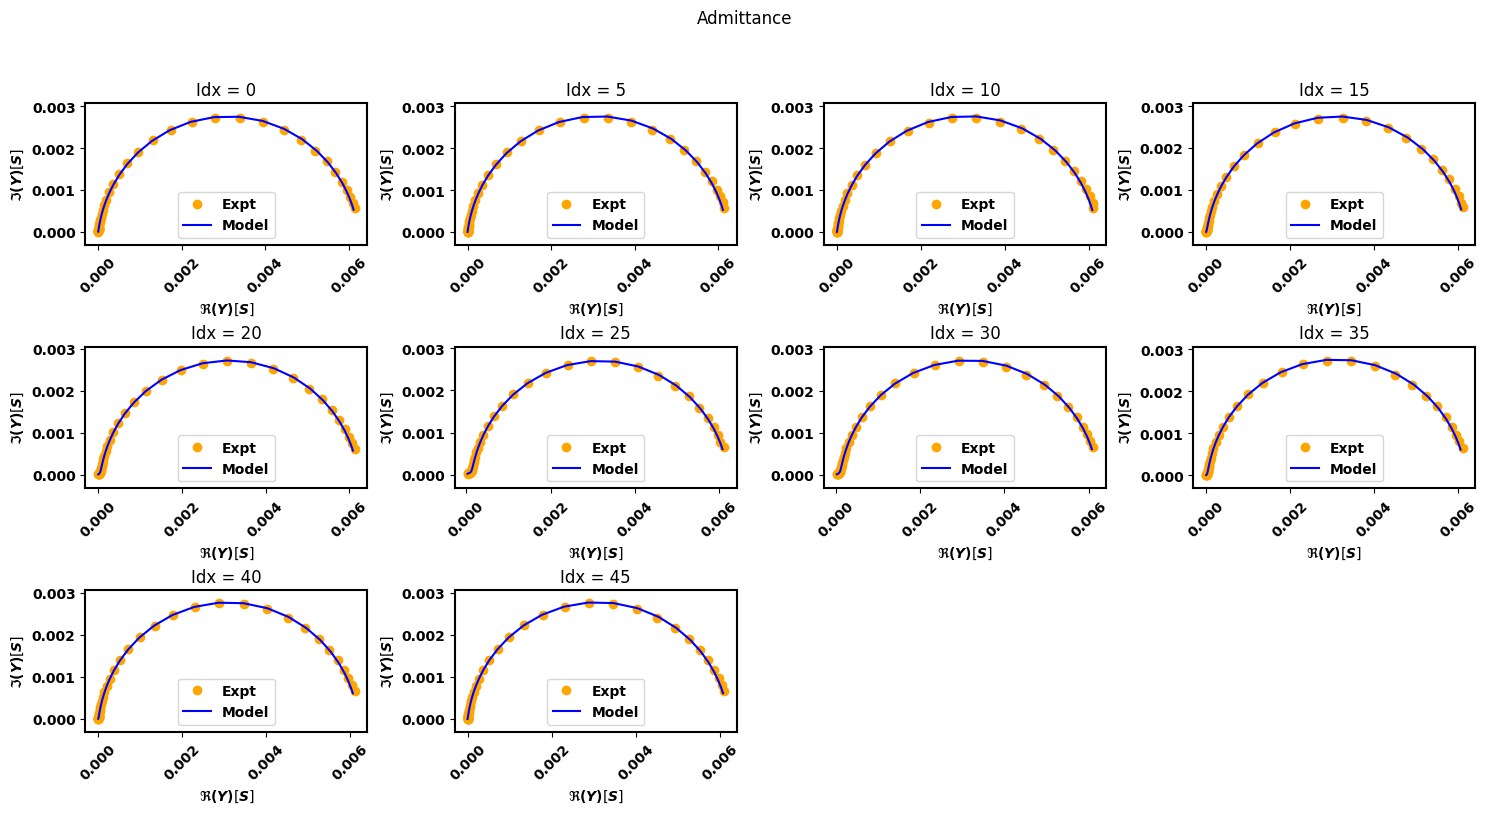

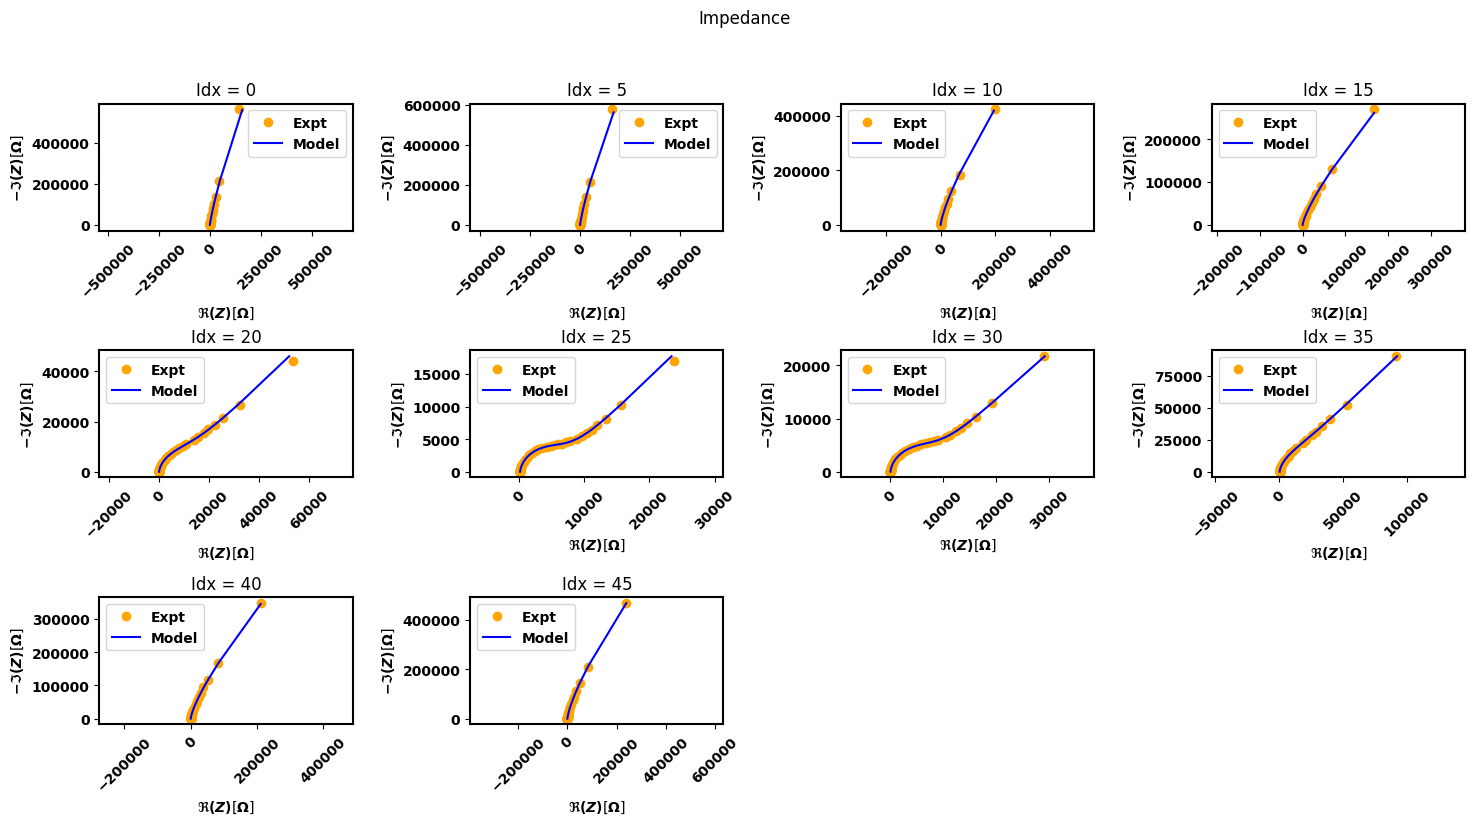

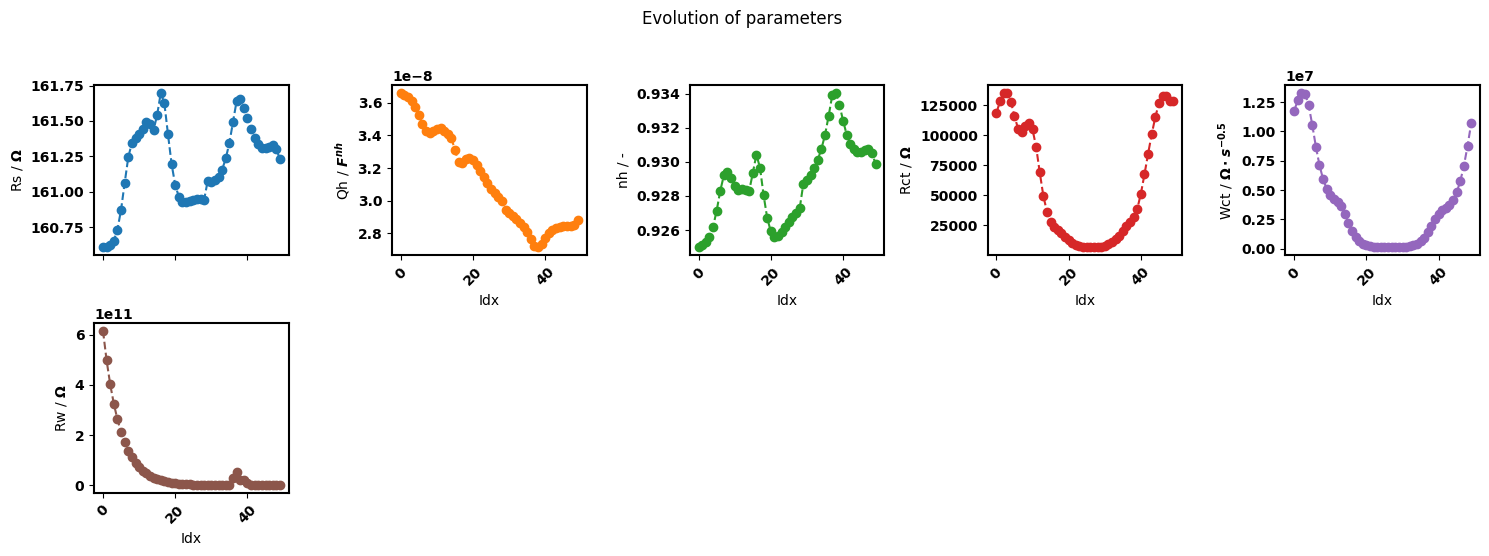

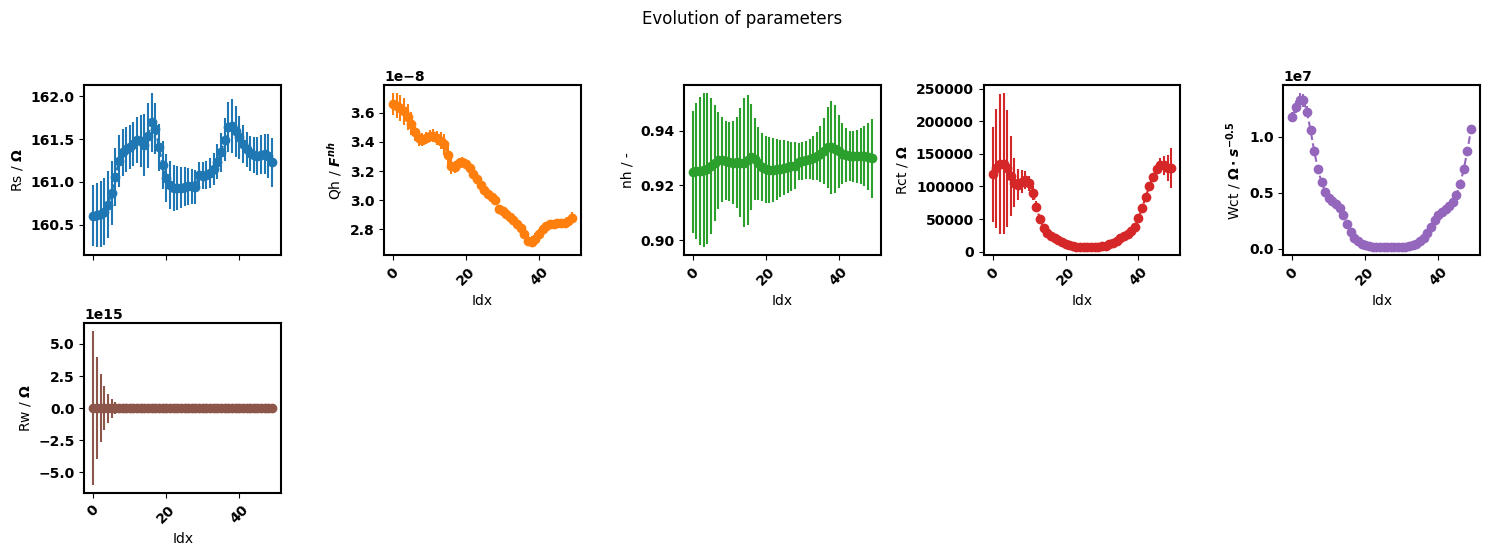

In [14]:
# Reinstantiate class
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_sequential(indices=None)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 3. Fitting with the stochastic option


Using initial
0: loss=4.119e-01
10000: loss=4.565e-05
20000: loss=3.768e-05
30000: loss=3.753e-05
40000: loss=3.749e-05
50000: loss=3.748e-05
60000: loss=3.747e-05
70000: loss=3.746e-05
80000: loss=3.746e-05
90000: loss=3.745e-05
Optimization complete
total time is 0:01:51.632921 

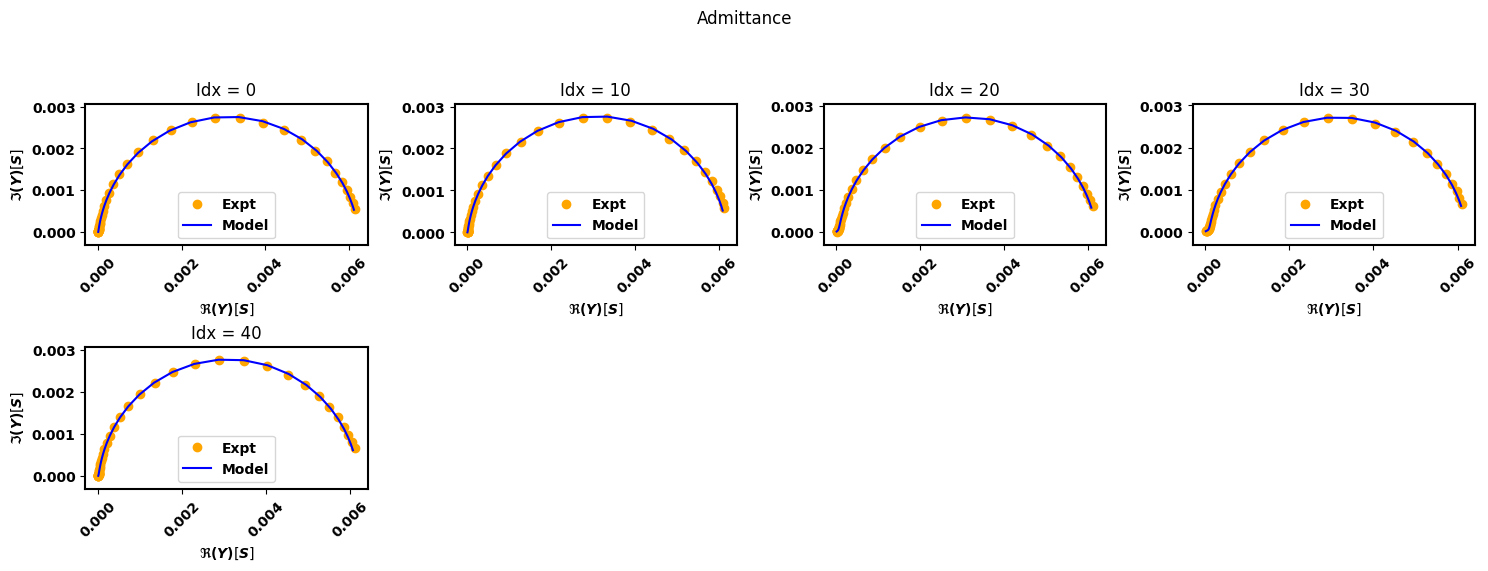

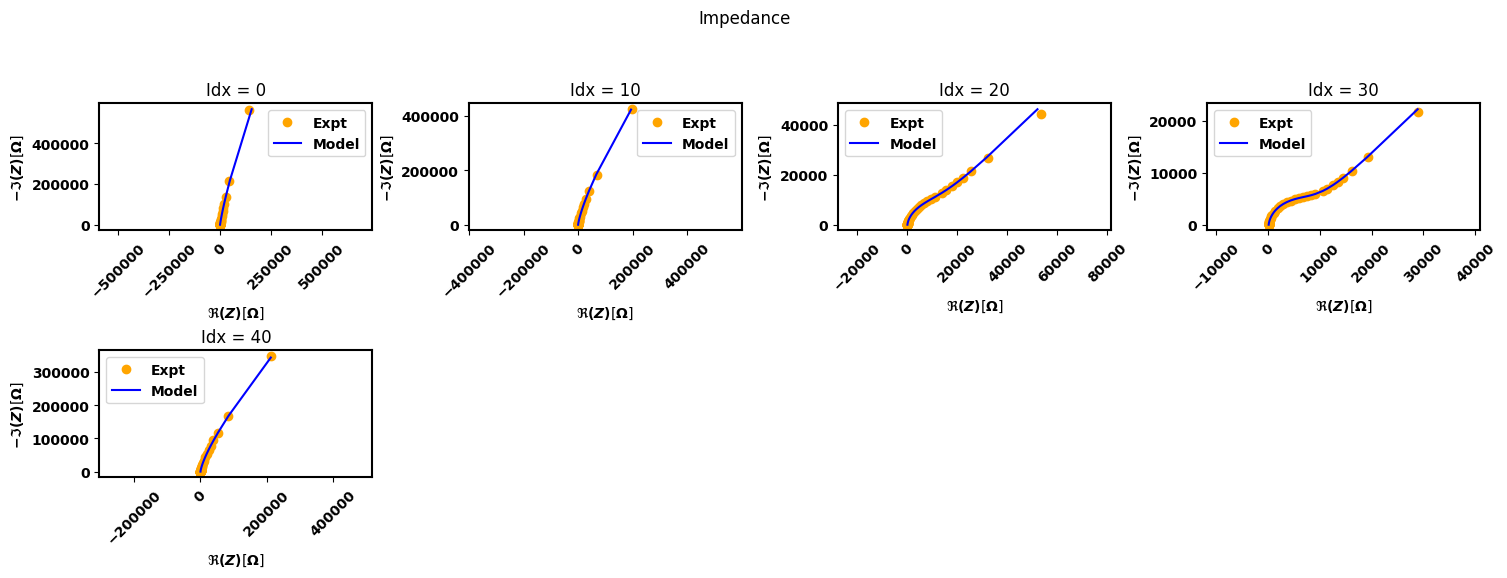

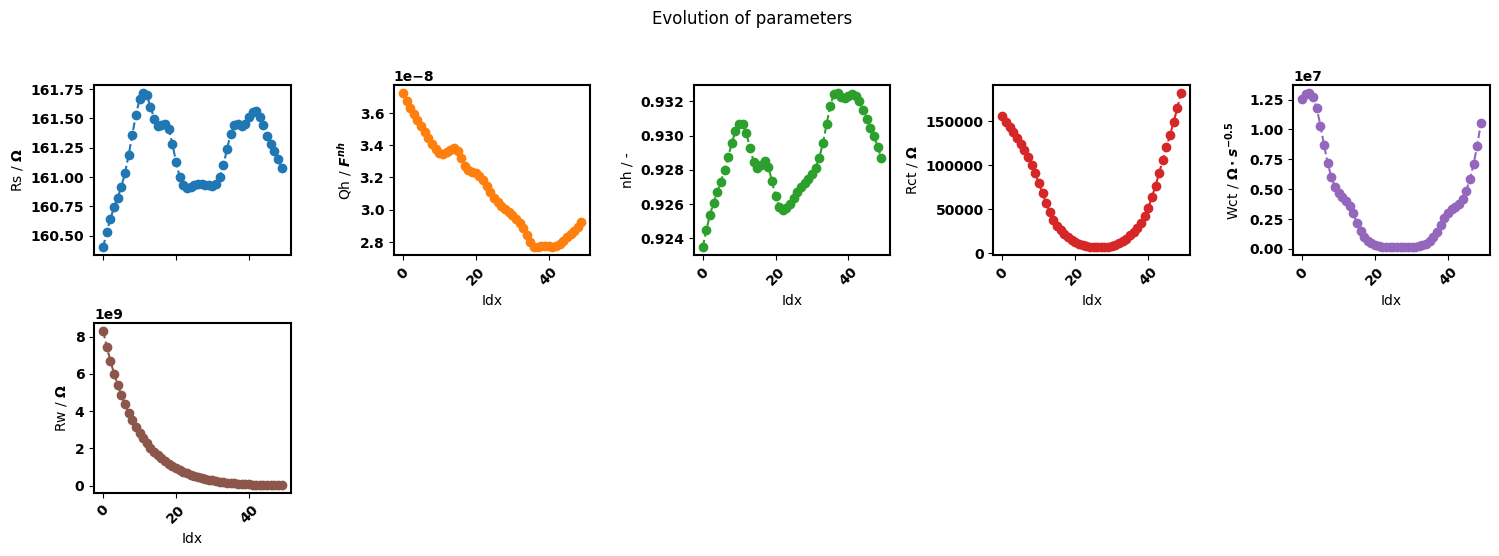

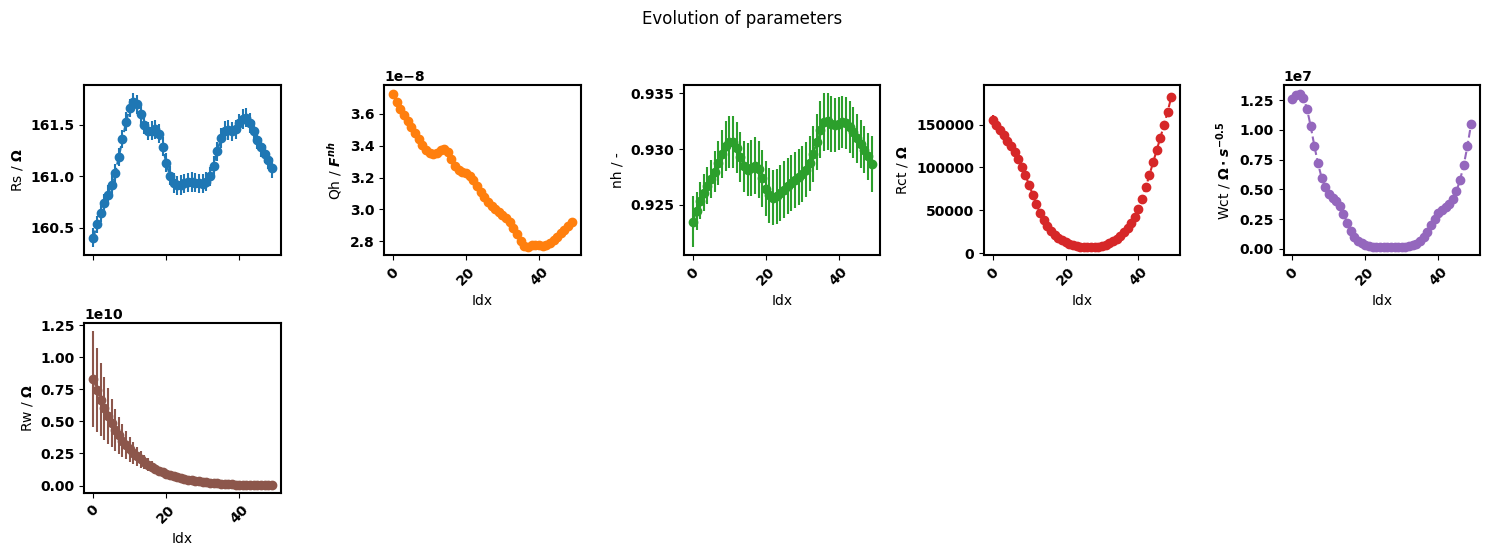

In [15]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_stochastic()
eis_redox_modulus.plot_nyquist(10)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 4. Running the Bootstrap MonteCarlo option


Using initial

Optimization complete
total time is 0:00:07.882804 
Please run fit_simultaneous() or fit_stochastic()
              on your data before running the compute_perr_mc() method.
              ignore this message if you did.

Optimization complete
total time is 0:43:47.656617 

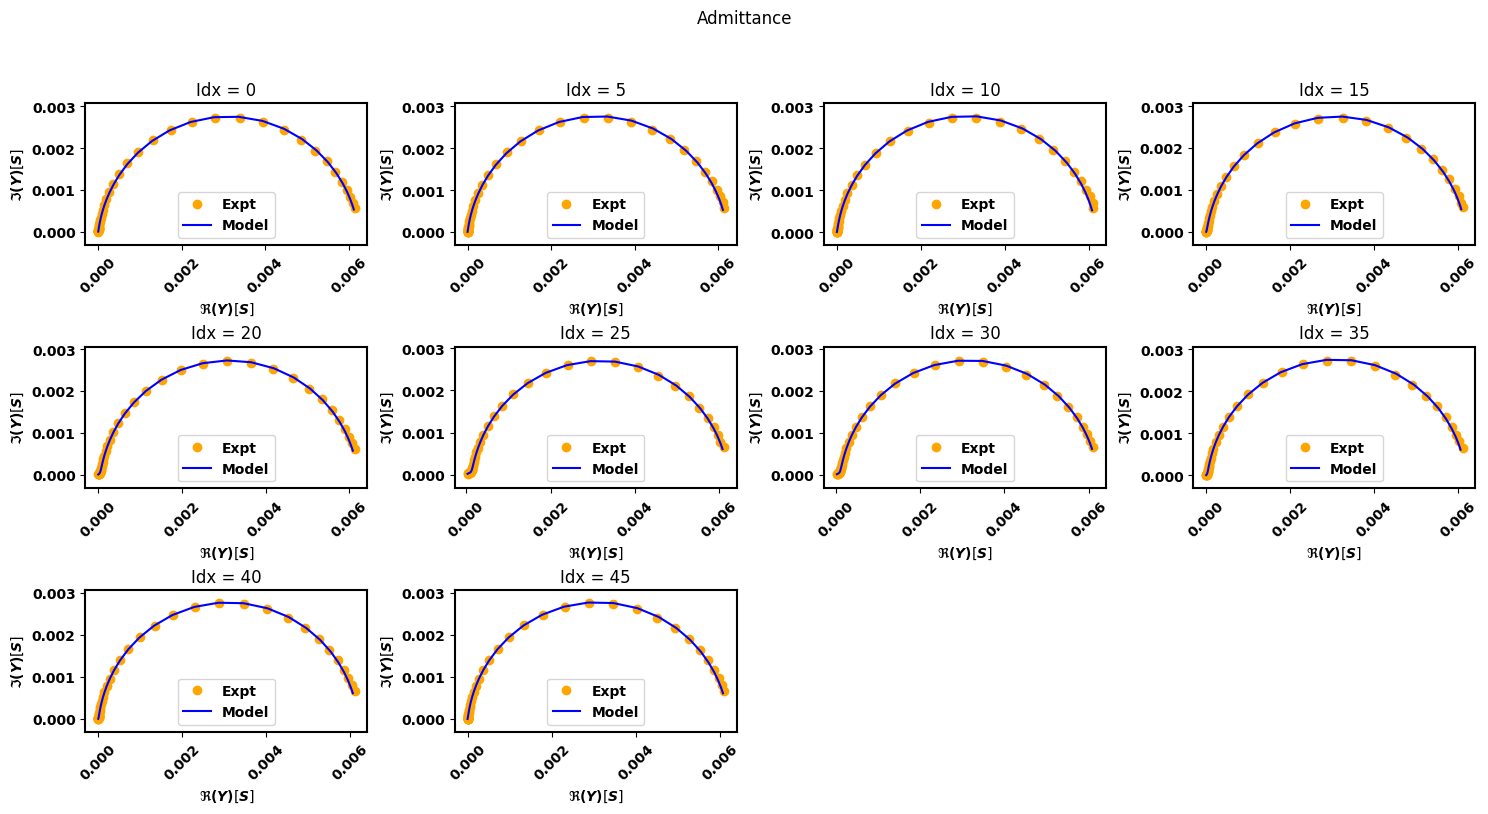

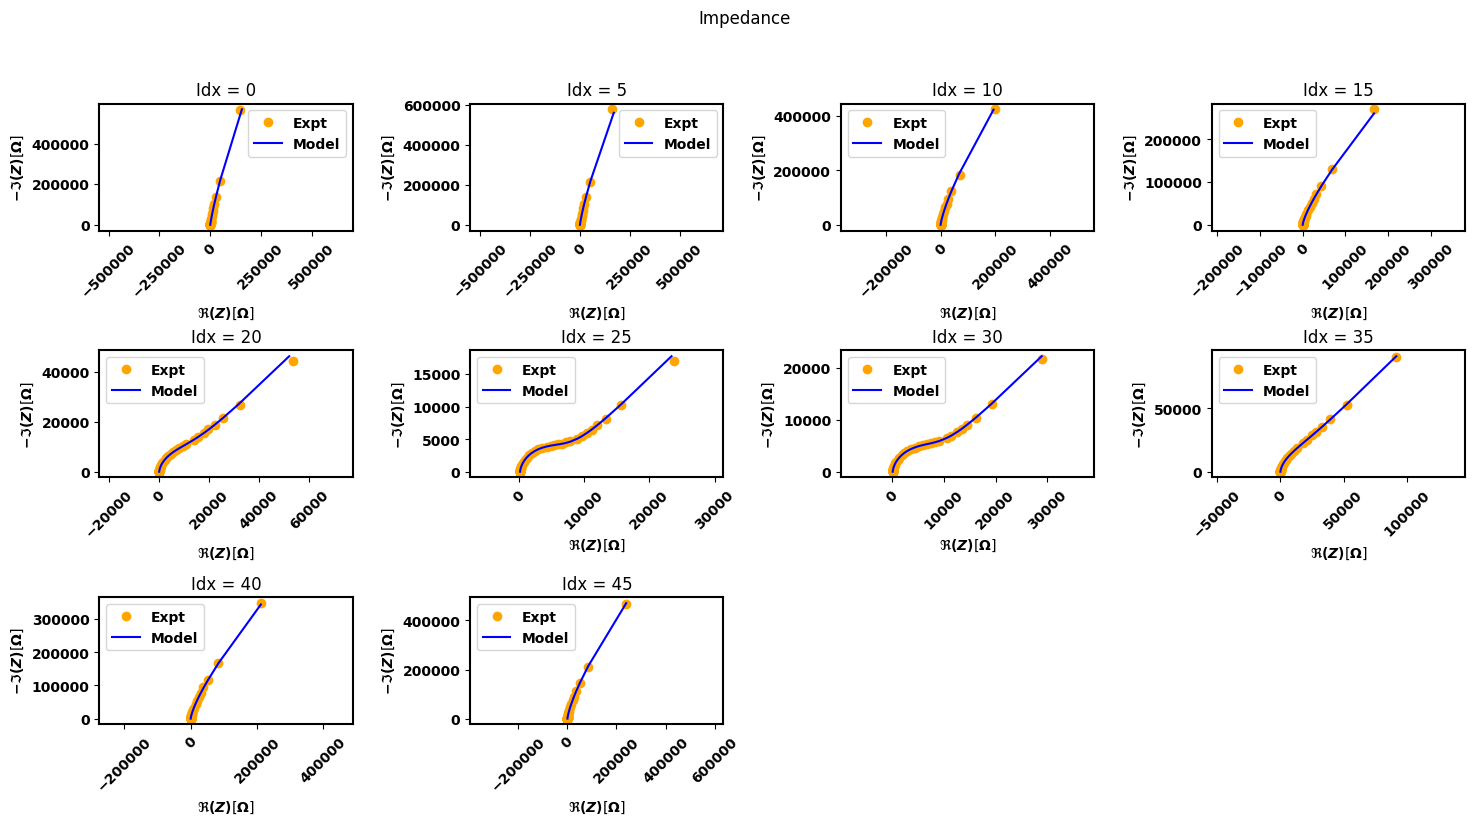

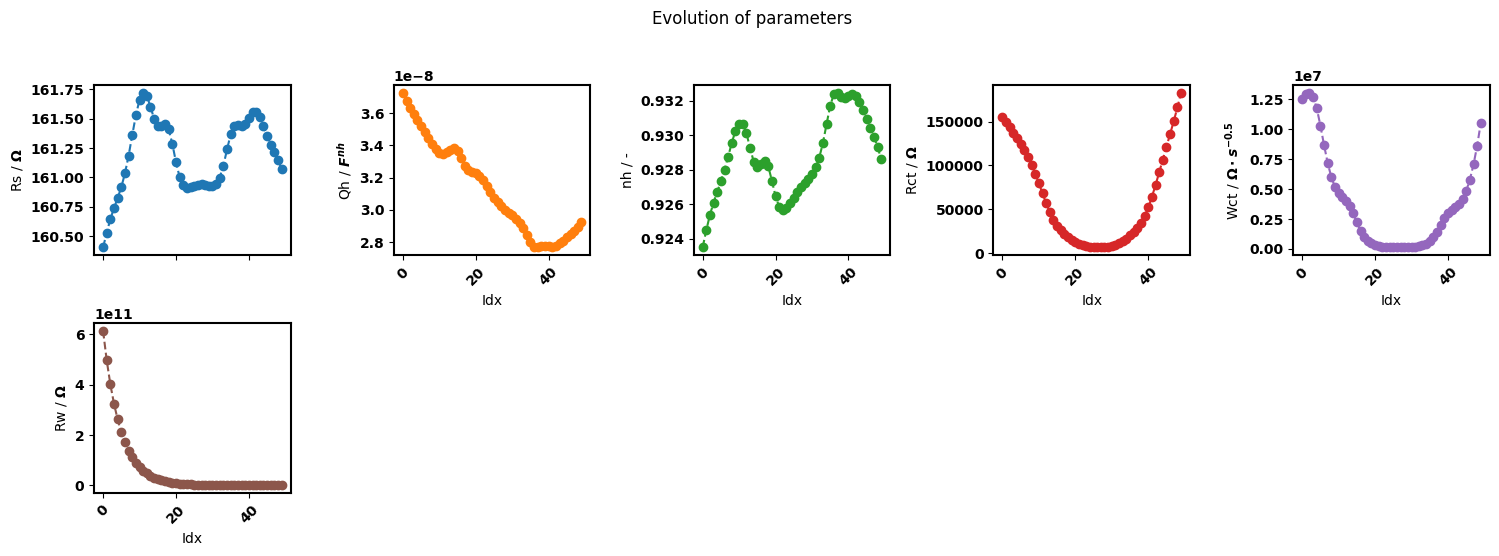

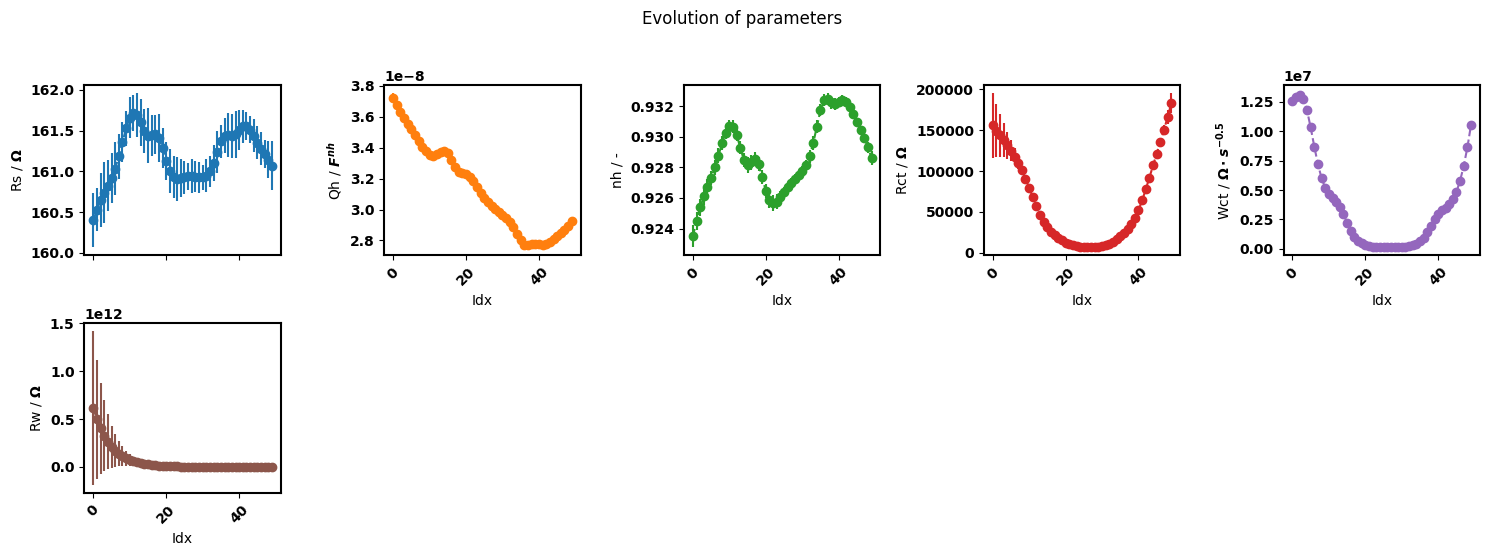

In [16]:
# Reinstantiate class and fit stochastic
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_modulus, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.compute_perr_mc(n_boots=500)
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 5. Keeping a parameter constant


Using initial

Optimization complete
total time is 0:00:11.090526 

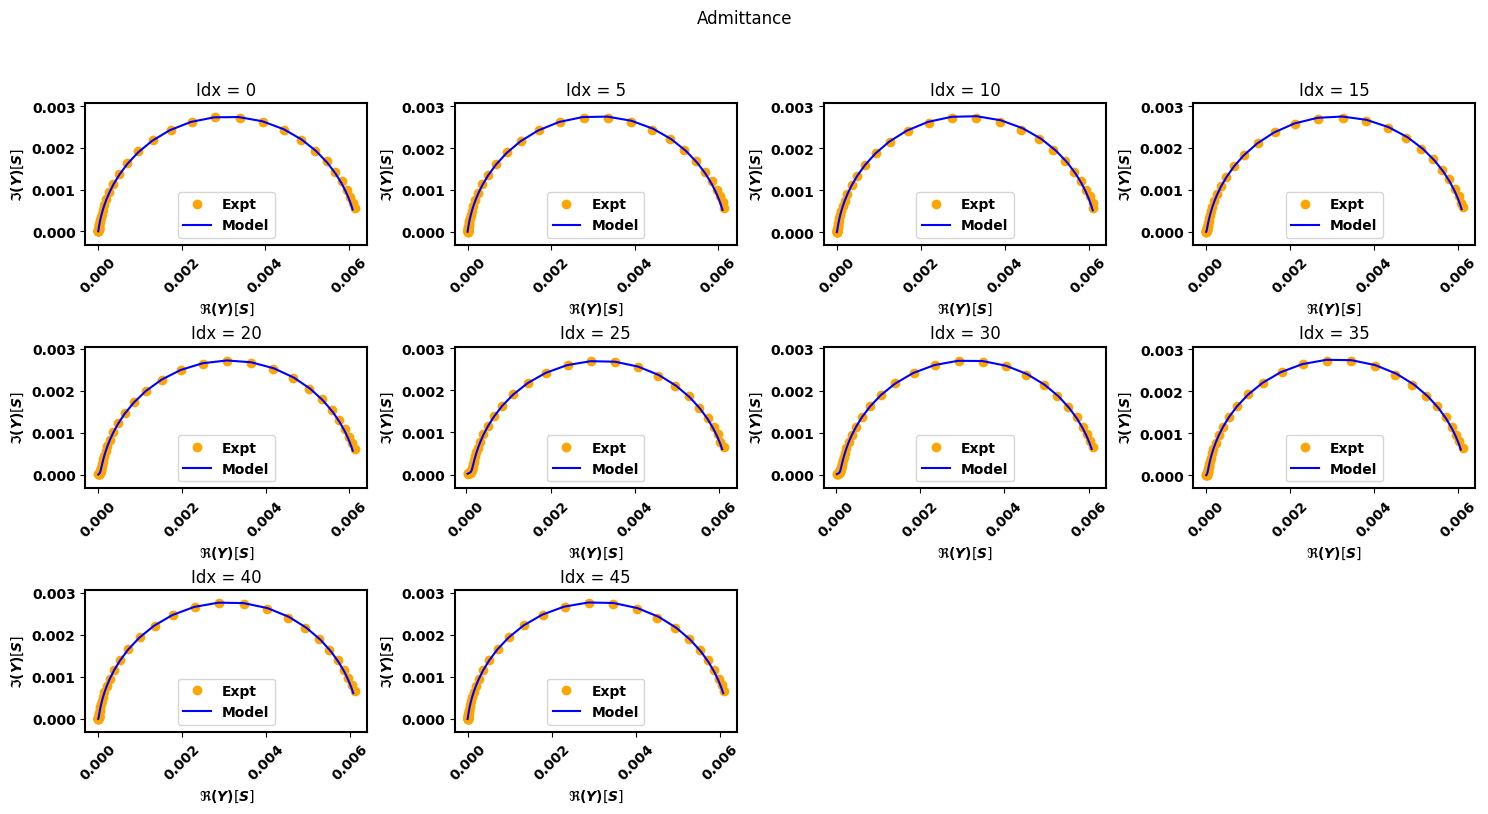

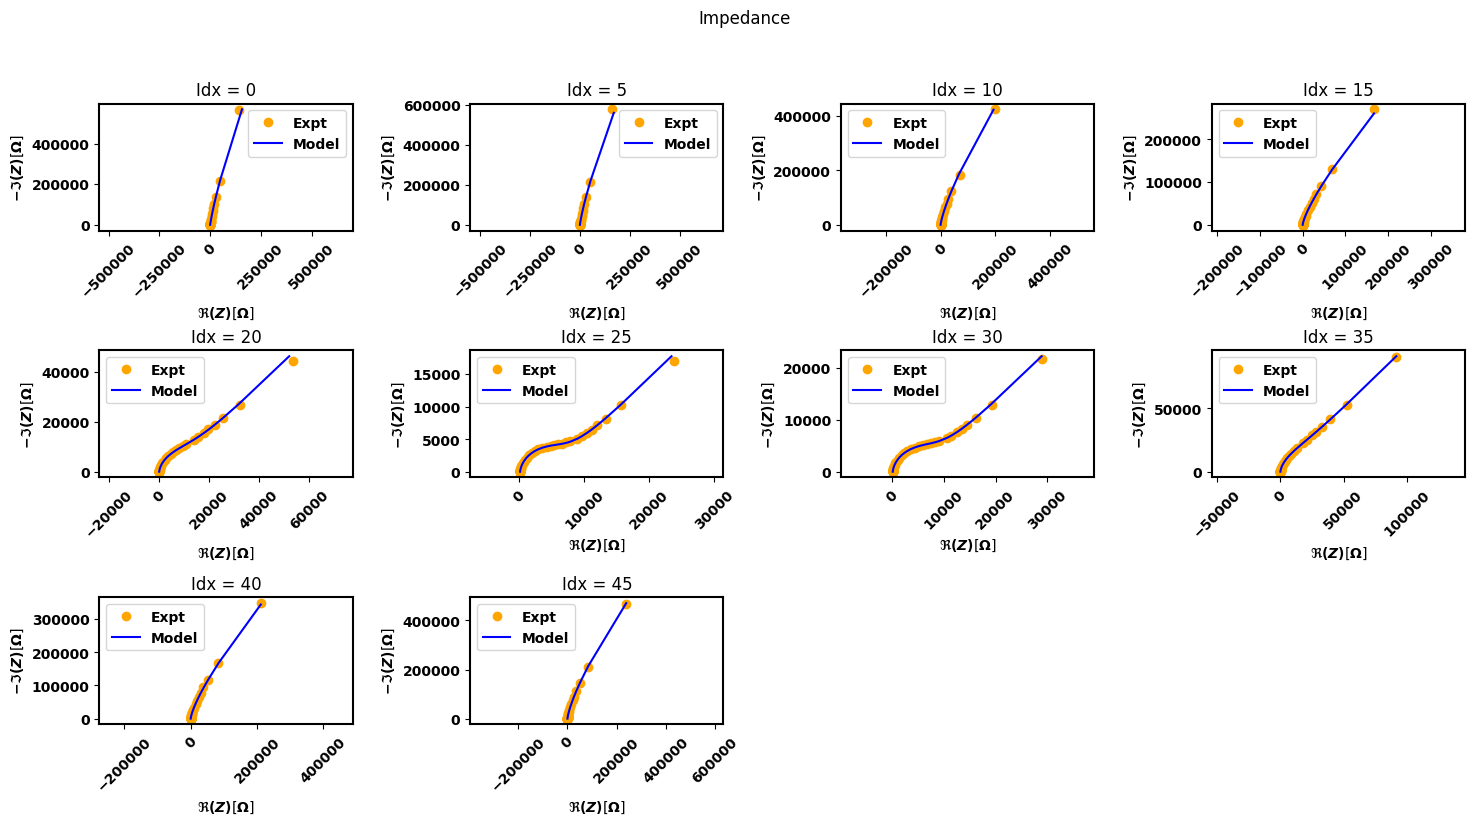

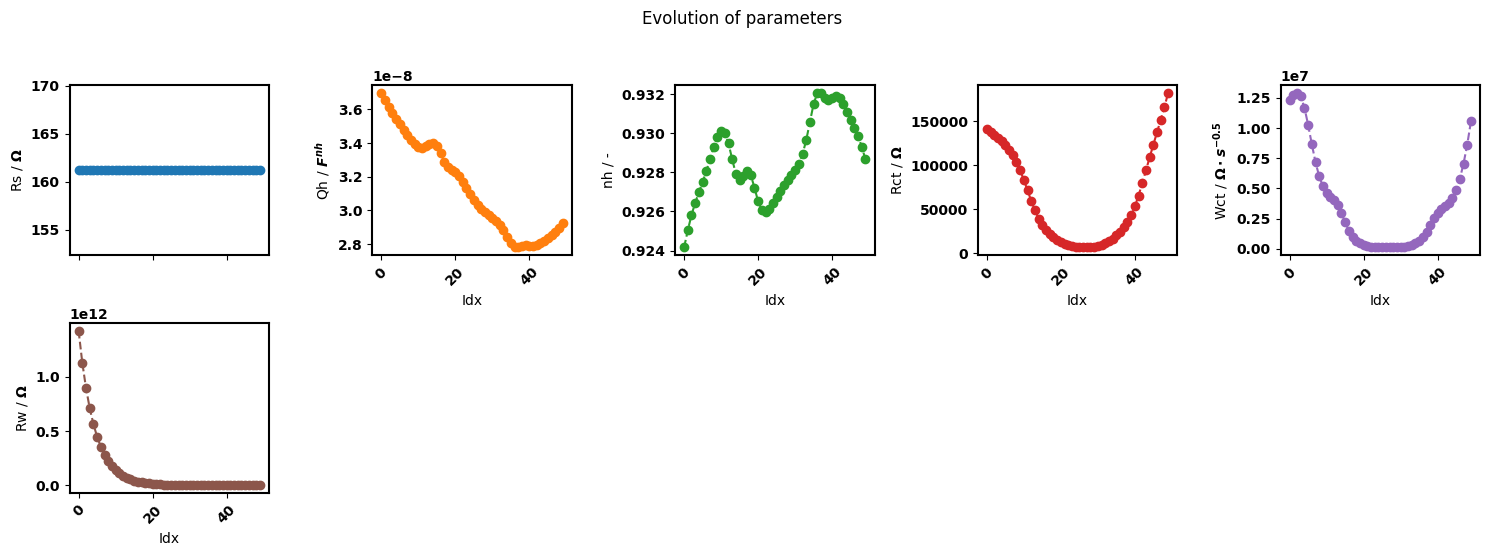

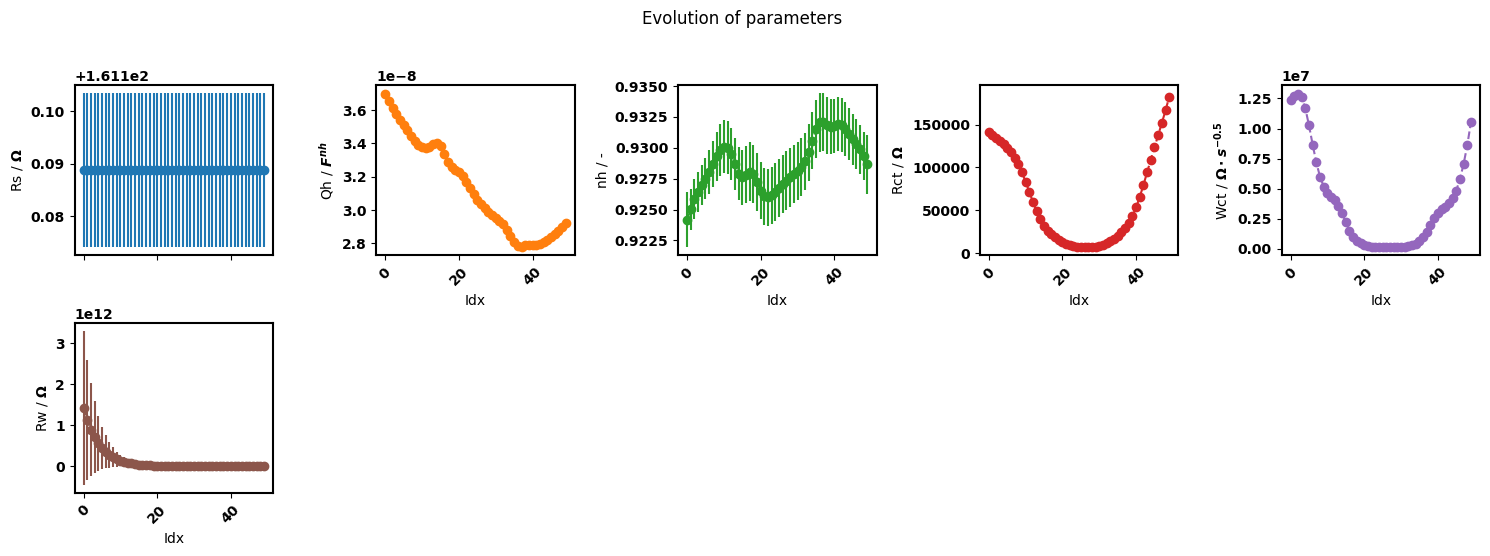

In [17]:
# Reinstantiate class and fit keeping a parameter constant
smf_const = smf_modulus.at[0].set(jnp.inf) # Here we use JAX's index update syntax to modify the element of smf_modulus
eis_redox_modulus = pym.Multieis(p0, F, Y, bounds, smf_const, redox, weight= 'modulus', immittance='admittance')
popt, perr, chisqr, chitot, AIC = eis_redox_modulus.fit_simultaneous(method = 'tnc')
eis_redox_modulus.plot_nyquist(5)
eis_redox_modulus.plot_params(show_errorbar = False, labels = labels)
eis_redox_modulus.plot_params(show_errorbar = True, labels = labels)

## 6. Saving the plots

In [18]:
eis_redox_modulus.save_plot_nyquist(steps=10, fname='example_results')
eis_redox_modulus.save_plot_bode(steps=10, fname='example_results')
eis_redox_modulus.save_plot_params(False, fname='example_results')

## 7. saving the results

In [19]:
eis_redox_modulus.save_results(fname='example_results')